
前 150 条高频共现边（格式：（词语1，词语2，共现频率））：
（人工，智能，38）
（企业，创新，31）
（企业，技术，21）
（创新，技术，17）
（企业，政策，17）
（创新，数字，16）
（消费者，行为，14）
（企业，风险，14）
（智能，生成式，14）
（数字，经济，14）
（政策，转型，14）
（创新，政策，13）
（政策，经济，13）
（数据，模态，13）
（金融，风险，13）
（企业，决策，13）
（企业，绿色，13）
（企业，行为，12）
（人工，生成式，12）
（协同，政策，12）
（企业，数字，11）
（决策，行为，11）
（信息，行为，11）
（资源，配置，11）
（信息，披露，10）
（市场，资本，10）
（企业，智能，10）
（经济，风险，10）
（企业，治理，10）
（政策，行为，10）
（治理，经济，9）
（决策，智能，9）
（气候，风险，9）
（人工，企业，9）
（产业，政策，9）
（协同，数据，9）
（绿色，转型，9）
（数据，风险，9）
（市场，政策，9）
（企业，数据，9）
（企业，经济，9）
（创新，网络，9）
（人机，协同，8）
（治理，风险，8）
（数据，行为，8）
（创新，经济，8）
（决策，数据，8）
（数字化，转型，8）
（生产，网络，8）
（供应链，平台，8）
（技术，数字，8）
（政策，风险，8）
（治理，行为，8）
（政策，绿色，8）
（企业，供应链，8）
（企业，核心，8）
（市场，金融，8）
（定价，资产，7）
（推断，统计，7）
（信息，环境，7）
（基础，设施，7）
（人机，决策，7）
（决策，协同，7）
（智能，行为，7）
（数字，治理，7）
（决策，投资，7）
（安全，风险，7）
（网络，风险，7）
（绿色，行为，7）
（干预，行为，7）
（创新，激励，7）
（信息，风险，7）
（安全，数据，7）
（定价，数据，7）
（产业，创新，7）
（企业，管理，7）
（经济，网络，7）
（多源，数据，7）
（模态，风险，7）
（媒体，社交，7）
（债务，风险，7）
（企业，网络，7）
（技术，智能，7）
（信息，金融，7）
（技术，突破，7）
（城市，空间，7）
（低碳，转型，7）
（决策，运营，7）
（技术，政策，7）
（信息，政策，7）
（企业，转型，7）
（企业，质量，7）
（信息，公司，6）


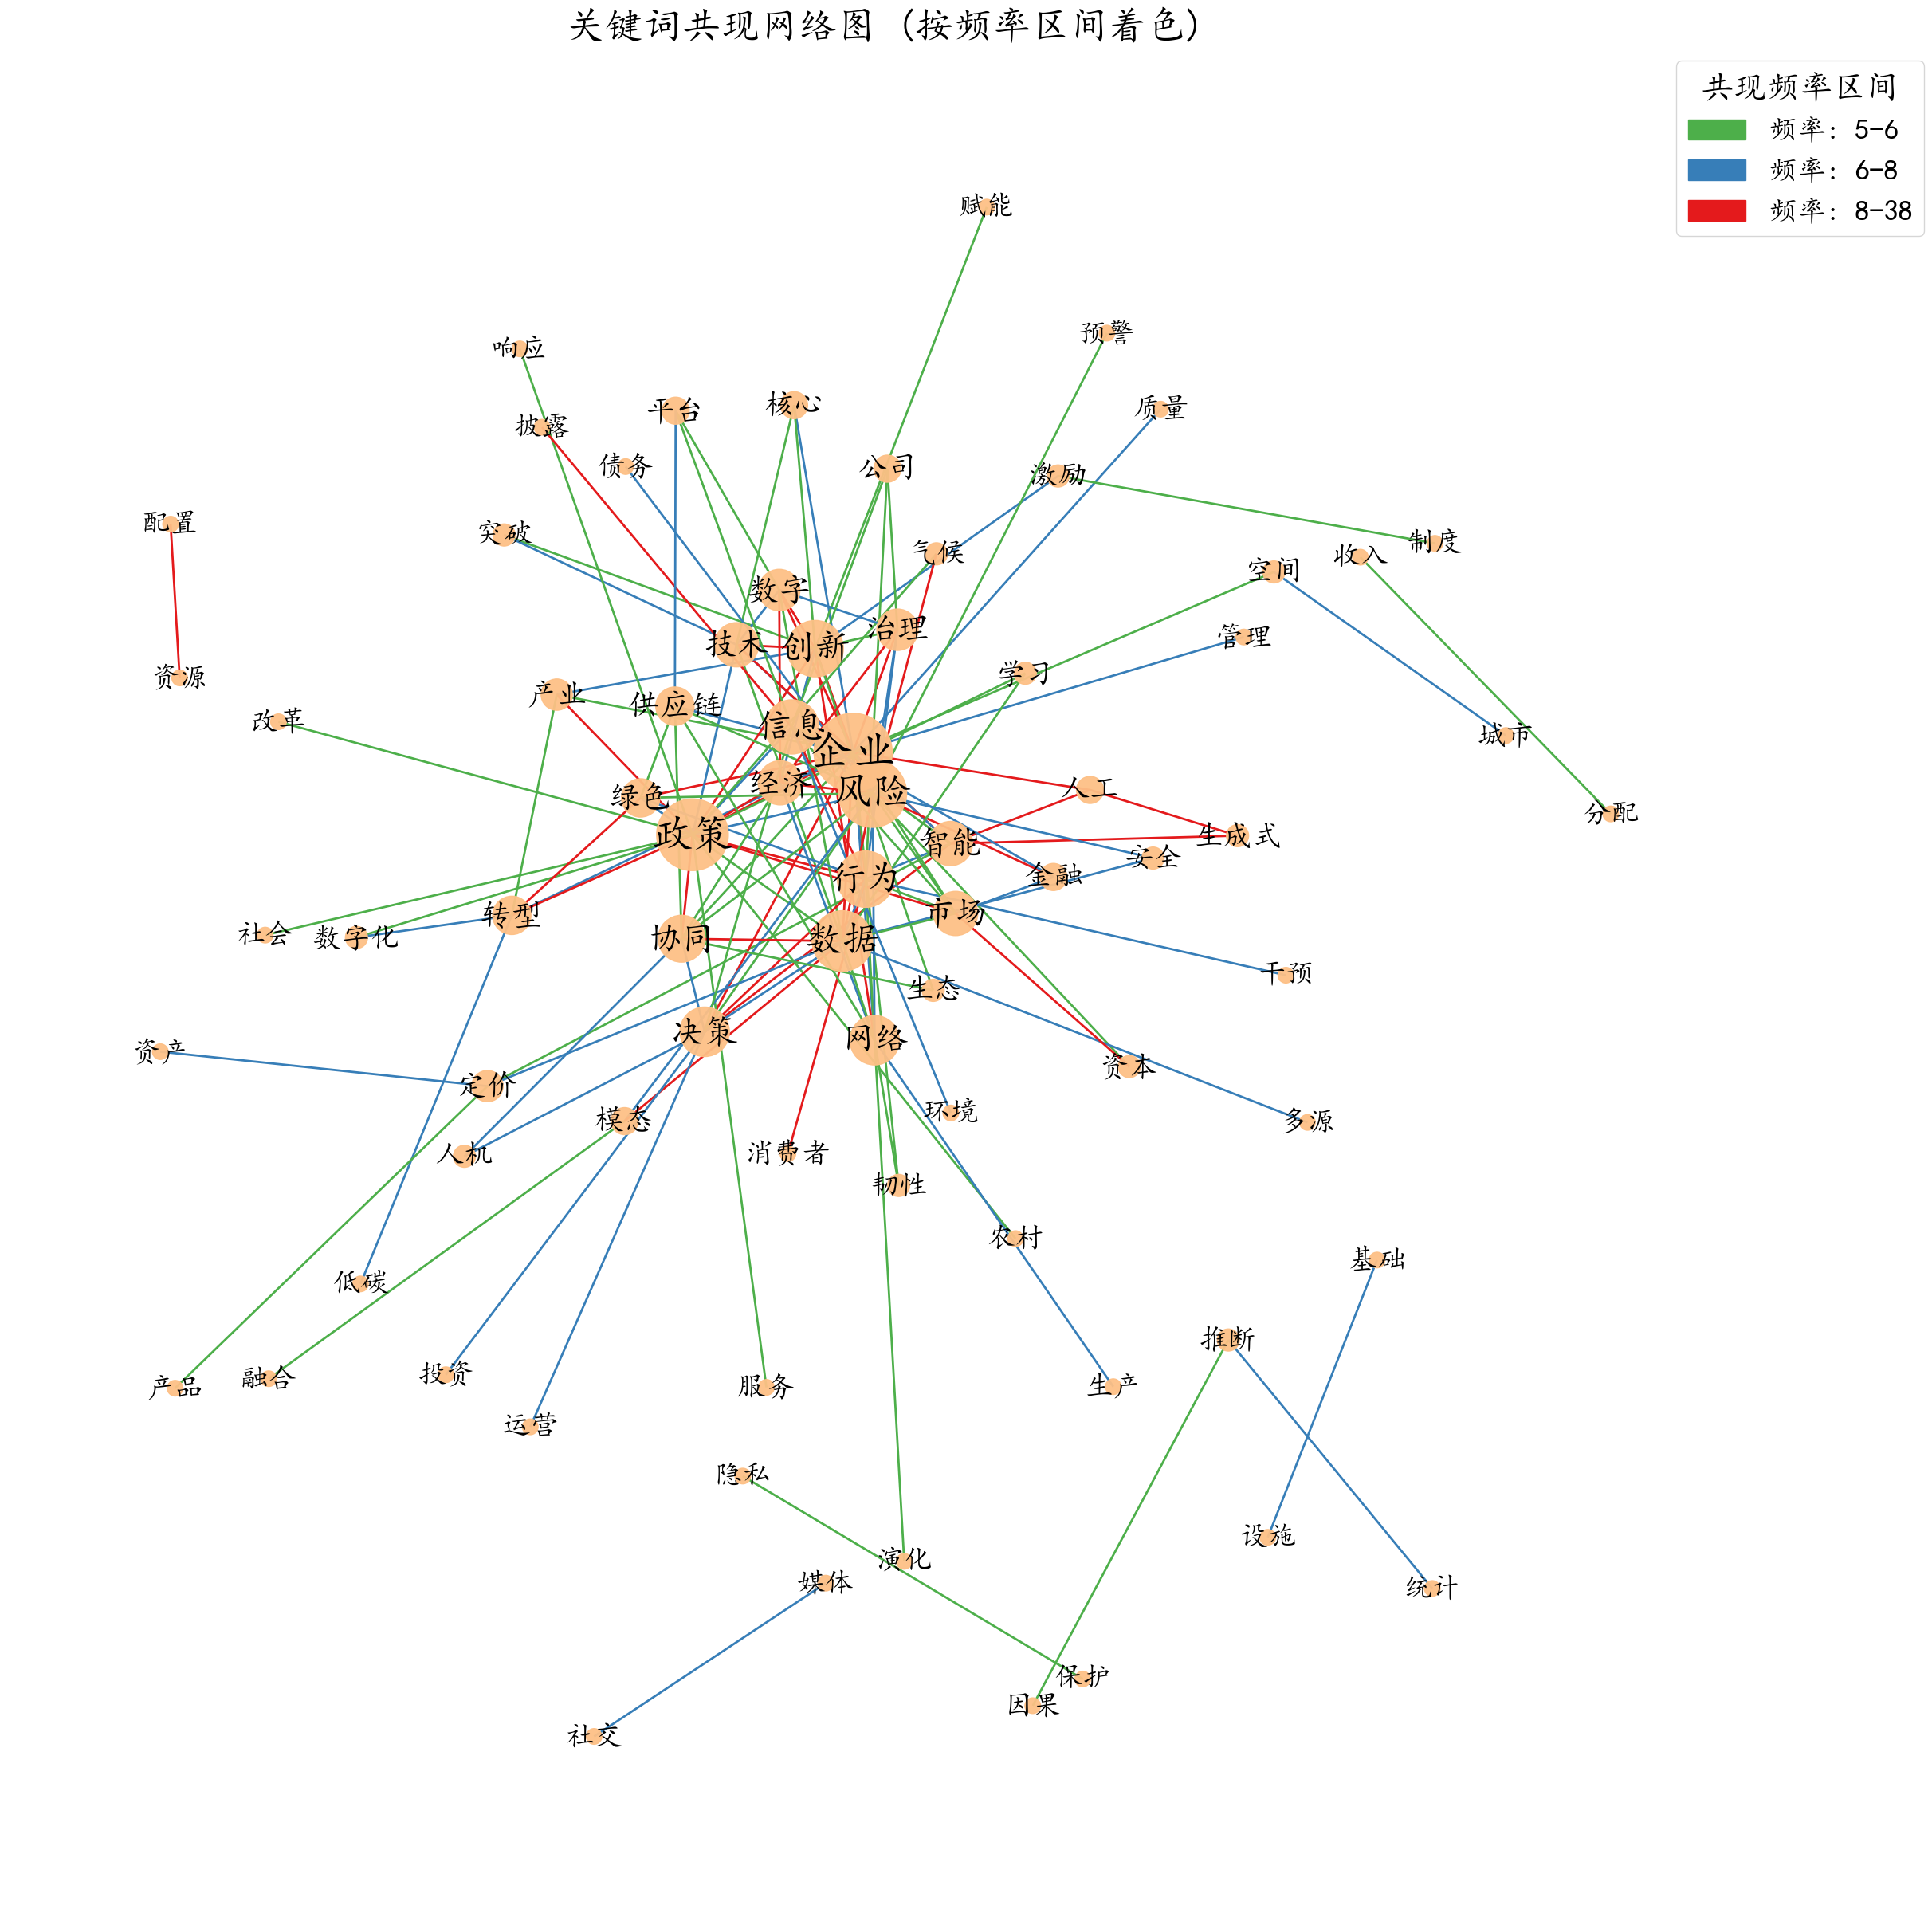

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
from collections import Counter
from itertools import combinations
import numpy as np

# --- 参数与资源设置 ---
font_path_chinese = "/kaggle/input/nsfc2025-management/simkai.ttf"
font_path_english = "/kaggle/input/nsfc2025-management/times.ttf"  # 备用，如需英文刻度等
csv_path = "/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv"

TOP_K_EDGES = 150
custom_stopwords = {'研究', '机制', '基于', '影响', '优化', '效应', '视角', '策略', 
                 '驱动', '理论', '机理', '路径', '动态', '分析', '应用', '作用', 
                 '模型', '方法', '评估', '及其', '设计', '中国', '模式', '形成', 
                 '发展', '结构', '系统', '背景', '提升', '后果', '实证', '考虑', 
                 '问题', '建模', '面向', '测度', '效果', '预测', '识别', '构建', 
                 '关键', '传导', '——'}

# 中文字体对象（用于标题/标签/节点文字）
ch_font = FontProperties(fname=font_path_chinese)

# --- 数据加载与网络构建 ---
df = pd.read_csv(csv_path, dtype=str, encoding="utf-8")
# 兼容：去除列名两侧空格，确保精确匹配“项目名称”“项目名称分词”
df.columns = [str(c).strip() for c in df.columns]

required_cols = {"项目名称", "项目名称分词"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"缺少必需列：{missing}；当前列为：{list(df.columns)}")

# 仅保留两列 & 去除缺失
df = df.loc[:, ["项目名称", "项目名称分词"]].dropna(subset=["项目名称分词"]).copy()

# 分词转列表
project_keywords_list = [str(text).split() for text in df['项目名称分词']]

# 计算共现
co_occurrences = []
for keywords in project_keywords_list:
    # 停用词与长度过滤（>1）
    keywords = [w for w in keywords if w not in custom_stopwords and len(w) > 1]
    # 生成两两组合
    for pair in combinations(sorted(set(keywords)), 2):
        co_occurrences.append(pair)

co_occurrence_counts = Counter(co_occurrences)

# ===== 打印 & 选取 TOP_K_EDGES =====
top_k_edges = co_occurrence_counts.most_common(TOP_K_EDGES)
if not top_k_edges:
    print("警告：未产生任何共现边（可能是分词列为空、或停用词过滤过严）。将不绘制图。")
else:
    print(f"\n前 {len(top_k_edges)} 条高频共现边（格式：（词语1，词语2，共现频率））：")
    for (w1, w2), c in top_k_edges:
        print(f"（{w1}，{w2}，{c}）")

    # 构建图
    G = nx.Graph()
    edges_to_add = [(w1, w2, {'weight': c}) for (w1, w2), c in top_k_edges]
    G.add_edges_from(edges_to_add)

    # --- 可视化网络图 ---
    fig = plt.figure(figsize=(24, 24))   # ← 用 fig 保存引用
    # spring_layout 复现性
    pos = nx.spring_layout(G, k=0.9, iterations=50, seed=42)
    
    node_degrees = dict(G.degree())
    node_sizes = [v * 200 for v in node_degrees.values()]
    NODE_COLOR = '#fdc086'
    
    # 边按频率分位着色
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
    if len(edge_weights) == 0:
        print("警告：没有边可绘制。")
    else:
        try:
            categories, bins = pd.qcut(edge_weights, q=3, labels=False, retbins=True, duplicates='drop')
        except ValueError:
            # 所有权重可能相同，qcut无法分箱
            categories = [0] * len(edge_weights)
            bins = [min(edge_weights), max(edge_weights)]
    
        color_palette = ['#4daf4a', '#377eb8', '#e41a1c']  # 绿/蓝/红
        edge_colors = [color_palette[int(cat)] for cat in categories]
    
        # 绘制节点和边
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=NODE_COLOR, alpha=0.95)
        nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors)
    
        # 图例（频率区间）
        legend_title_font = FontProperties(fname=font_path_chinese, size=30)
        legend_prop_font  = FontProperties(fname=font_path_chinese, size=26)
        legend_patches = []
        for i in range(len(bins) - 1):
            lb, ub = int(bins[i]), int(bins[i+1])
            label = f'频率: {lb}-{ub}'
            legend_patches.append(mpatches.Patch(color=color_palette[i % len(color_palette)], label=label))
    
        plt.legend(
            handles=legend_patches,
            prop=legend_prop_font,
            title="共现频率区间",
            title_fontproperties=legend_title_font,
            loc='upper right',
            bbox_to_anchor=(1.1, 1.0)
        )
    
        # 节点文字（按度数缩放字号）
        font_prop = FontProperties(fname=font_path_chinese)
        MIN_FONT_SIZE, MAX_FONT_SIZE = 26, 40
        if node_degrees:
            min_degree, max_degree = min(node_degrees.values()), max(node_degrees.values())
            if max_degree == min_degree:
                normalized_degrees = {node: 0.5 for node in node_degrees}
            else:
                normalized_degrees = {
                    node: (deg - min_degree) / (max_degree - min_degree)
                    for node, deg in node_degrees.items()
                }
            for node, (x, y) in pos.items():
                font_size = MIN_FONT_SIZE + normalized_degrees[node] * (MAX_FONT_SIZE - MIN_FONT_SIZE)
                plt.text(x, y, node, fontproperties=font_prop, fontsize=font_size,
                         ha='center', va='center', fontweight='bold')
    
        # 标题与保存 & 显示
        plt.title('关键词共现网络图 (按频率区间着色)', fontproperties=ch_font, fontsize=35)
        plt.axis('off')
        plt.tight_layout()
    
        out_png = 'keyword_cooccurrence_network_overall.png'
        try:
            fig.savefig(out_png, dpi=300, bbox_inches='tight')   # ← 用 fig.savefig
            print(f"\n图已保存：{out_png}")
        except Exception as e:
            print(f"保存图表时出错：{e}")
    
        # 在 Kaggle/Notebook 中显示
        plt.show()          # ← 显示图像
        plt.close(fig)      # ← 关闭释放内存




In [4]:
!pip install -q pyvis

import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
from itertools import combinations
from IPython.display import IFrame, display

# --- 参数与资源设置 ---
csv_path = "/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv"
TOP_K_EDGES = 500
custom_stopwords = {'研究', '机制', '基于', '影响', '优化', '效应', '视角', '策略', 
                 '驱动', '理论', '机理', '路径', '动态', '分析', '应用', '作用', 
                 '模型', '方法', '评估', '及其', '设计', '中国', '模式', '形成', 
                 '发展', '结构', '系统', '背景', '提升', '后果', '实证', '考虑', 
                 '问题', '建模', '面向', '测度', '效果', '预测', '识别', '构建', 
                 '关键', '传导', '——'}

# --- 数据加载与预处理（仅两列） ---
df = pd.read_csv(csv_path, dtype=str, encoding="utf-8")
# 统一去除列名空格，兼容 “项目名称分词 ”
df.columns = [str(c).strip() for c in df.columns]

required_cols = {"项目名称", "项目名称分词"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"缺少必需列：{missing}；当前列为：{list(df.columns)}")

# 仅保留两列并清洗
df = df.loc[:, ["项目名称", "项目名称分词"]].dropna(subset=["项目名称分词"]).copy()
project_keywords_list = [str(text).split() for text in df["项目名称分词"]]

# --- 计算共现 ---
co_occurrences = []
for keywords in project_keywords_list:
    # 去停用词、去长度为1
    keywords = [w for w in keywords if w not in custom_stopwords and len(w) > 1]
    # 用 set 去重再两两组合
    for pair in combinations(sorted(set(keywords)), 2):
        co_occurrences.append(pair)

co_occurrence_counts = Counter(co_occurrences)
top_k_edges = co_occurrence_counts.most_common(TOP_K_EDGES)

if not top_k_edges:
    raise RuntimeError("未产生任何共现边（可能是分词列为空或停用词过严）。")

# --- 使用 NetworkX 构建图 ---
G = nx.Graph()
G.add_edges_from([(w1, w2, {"weight": c}) for (w1, w2), c in top_k_edges])

# 节点/边属性
node_degrees = dict(G.degree())
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]

# 安全范围计算
MIN_NODE_SIZE, MAX_NODE_SIZE = 30, 50
MIN_LABEL_SIZE, MAX_LABEL_SIZE = 12, 28
MIN_EDGE_WIDTH, MAX_EDGE_WIDTH = 1, 10

min_degree = min(node_degrees.values()) if node_degrees else 0
max_degree = max(node_degrees.values()) if node_degrees else 1
min_weight = min(edge_weights) if edge_weights else 1
max_weight = max(edge_weights) if edge_weights else 1

# === 新增：复用“静态图”配色方案 ===
import pandas as pd
palette = ['#4daf4a', '#377eb8', '#e41a1c']  # 绿/蓝/红（与静态一致）
weights_in_order = [c for (_, _), c in top_k_edges]

# 三分位分箱，得到每条边所在分箱（与 top_k_edges 顺序对应）
try:
    cats, bins = pd.qcut(weights_in_order, q=3, labels=False, retbins=True, duplicates='drop')
except ValueError:
    # 权重全相同时 qcut 可能失败：全部归为一类
    cats = [0] * len(weights_in_order)
    bins = [min(weights_in_order), max(weights_in_order)]

# 构建颜色字典：以排序后的节点对作为 key，保证查找稳定
edge_color_dict = {}
for ((u, v), w), c in zip(top_k_edges, cats):
    key = tuple(sorted((u, v)))
    edge_color_dict[key] = palette[int(c)]

# --- PyVis 交互式可视化 ---
net = Network(
    height="820px",
    width="100%",
    notebook=True,
    heading="关键词共现网络图（交互版）",
    directed=False
)

# 节点（与静态图一致的节点色）
NODE_COLOR = "#fdc086"
for node, degree in node_degrees.items():
    # 节点圆圈大小
    if max_degree > min_degree:
        size = MIN_NODE_SIZE + (degree - min_degree) * (MAX_NODE_SIZE - MIN_NODE_SIZE) / (max_degree - min_degree)
    else:
        size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2

    # 同步映射标签字号
    if MAX_NODE_SIZE > MIN_NODE_SIZE:
        label_size = MIN_LABEL_SIZE + (size - MIN_NODE_SIZE) * (MAX_LABEL_SIZE - MIN_LABEL_SIZE) / (MAX_NODE_SIZE - MIN_NODE_SIZE)
    else:
        label_size = (MIN_LABEL_SIZE + MAX_LABEL_SIZE) / 2

    net.add_node(
        node,
        label=node,
        size=float(size),
        color=NODE_COLOR,  # ★ 与静态图一致
        title=f"关键词：{node}\n连接数：{degree}",
        font={"size": int(label_size), "bold": True, "strokeWidth": 2, "strokeColor": "#ffffff"}
    )

# 边（三分位颜色 + 宽度映射）
for u, v, data in G.edges(data=True):
    w = data["weight"]
    if max_weight > min_weight:
        width = MIN_EDGE_WIDTH + (w - min_weight) * (MAX_EDGE_WIDTH - MIN_EDGE_WIDTH) / (max_weight - min_weight)
    else:
        width = (MIN_EDGE_WIDTH + MAX_EDGE_WIDTH) / 2

    key = tuple(sorted((u, v)))
    ecolor = edge_color_dict.get(key, palette[0])

    net.add_edge(
        u, v,
        width=float(width),
        value=int(w),               # 用真实权重参与物理布局
        color=ecolor,               # ★ 与静态图一致的边颜色
        title=f"{{{u}，{v}}} 共现频率：{w}"
    )

# 交互/物理参数（JSON 字符串）
net.set_options(
    """
    {
      "layout": { "improvedLayout": true },
      "interaction": { "hover": true, "tooltipDelay": 120, "zoomView": true, "dragNodes": true },
      "configure": { "enabled": true, "filter": ["physics"] },
      "nodes": {
        "font": { "face": "SimKai, KaiTi, Microsoft YaHei, Arial", "size": 18 }
      },
      "edges": {
        "smooth": { "type": "dynamic" }
      },
      "physics": {
        "enabled": true,
        "solver": "barnesHut",
        "stabilization": { "enabled": true, "iterations": 1600, "updateInterval": 25, "fit": true },
        "timestep": 0.35,
        "maxVelocity": 20,
        "minVelocity": 0.75,
        "barnesHut": {
          "gravitationalConstant": -3800,
          "centralGravity": 0.28,
          "springLength": 135,
          "springConstant": 0.018,
          "damping": 0.72,
          "avoidOverlap": 0.25
        }
      }
    }
    """
)

# （可选）右上角“伪图例”
legend_y0 = -420  # 顶部 y 基准（随画布大小可微调）
for i in range(len(bins) - 1):
    label = f"频率: {int(bins[i])}-{int(bins[i+1])}"
    net.add_node(
        f"_legend_{i}", label=label, shape="box", color=palette[i % len(palette)],
        x=900, y=legend_y0 + i * 60, fixed={"x": True, "y": True}, physics=False,
        font={"size": 18, "bold": True, "color": "#222"}
    )

# 保存并在 Notebook 中显示
html_path = "interactive_keyword_network_same_style.html"
net.show(html_path)  # 会保存并在 Notebook 中内嵌（notebook=True）

print(f"动态交互式网络图（与静态配色一致）已生成：{html_path}")
display(IFrame(src=html_path, width="100%", height=840))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.0 MB/s eta 0:00:0000:010:01
interactive_keyword_network_same_style.html
动态交互式网络图（与静态配色一致）已生成：interactive_keyword_network_same_style.html
